In [1]:
import pandas as pd
import numpy as np
import os
from keras.layers import Dense, Flatten, AveragePooling2D, Dropout
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
%matplotlib inline
from skimage.segmentation import mark_boundaries
import lime
from lime import lime_image
import cv2

In [2]:
data_path = 'Data'

In [3]:
baseModel = VGG16(input_shape=(224,224,3), weights='imagenet', include_top=False)

for layer in baseModel.layers:
  layer.trainable = False

headModel = baseModel.output
headModel = AveragePooling2D()(headModel)
headModel = Flatten()(headModel)
headModel = Dense(64, activation="relu")(headModel)
headModel = Dropout(0.2)(headModel)
headModel = Dense(3, activation='softmax')(headModel)

model = Model(inputs=baseModel.input, outputs=headModel)

In [4]:
print("Base Model loaded !")
baseModel.summary()

Base Model loaded !
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 5

In [5]:
print("Total Model loaded !")
model.summary()

Total Model loaded !
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 

In [6]:
from keras.optimizers import Adam
Optimizer=Adam(learning_rate=0.001)
model.compile(optimizer=Optimizer,loss='categorical_crossentropy',metrics=['accuracy'])

In [7]:
datagen = ImageDataGenerator(horizontal_flip=True,vertical_flip=True,rotation_range=20,zoom_range=0.2,
                    width_shift_range=0.2,height_shift_range=0.2,shear_range=0.1,fill_mode="nearest")
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   zoom_range = 0.2,
                                   rotation_range=15,
                                   horizontal_flip = True,
                                   vertical_flip=True,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.1,
                                   fill_mode="nearest")

test_datagen = ImageDataGenerator(rescale = 1./255)

training_gen = train_datagen.flow_from_directory(data_path + '/train',
                                                 target_size = (224, 224),
                                                 batch_size = 16,
                                                 class_mode = 'categorical',
                                                 shuffle=True)

test_gen = test_datagen.flow_from_directory(data_path + '/test',
                                            target_size = (224, 224),
                                            batch_size = 16,
                                            class_mode = 'categorical',
                                            shuffle = False)

Found 5144 images belonging to 3 classes.
Found 1288 images belonging to 3 classes.


In [8]:
history1 = model.fit(training_gen,validation_data=test_gen,epochs=50)

Epoch 1/50
322/322 [==============================] - 1408s 4s/step - loss: 0.5416 - accuracy: 0.7766 - val_loss: 0.2332 - val_accuracy: 0.9177
Epoch 2/50
322/322 [==============================] - 1363s 4s/step - loss: 0.3103 - accuracy: 0.8773 - val_loss: 0.2349 - val_accuracy: 0.9053
Epoch 3/50
322/322 [==============================] - 1267s 4s/step - loss: 0.2933 - accuracy: 0.8806 - val_loss: 0.2674 - val_accuracy: 0.8936
Epoch 4/50
322/322 [==============================] - 1386s 4s/step - loss: 0.2773 - accuracy: 0.8842 - val_loss: 0.2136 - val_accuracy: 0.9130
Epoch 5/50
322/322 [==============================] - 1392s 4s/step - loss: 0.2548 - accuracy: 0.8989 - val_loss: 0.1988 - val_accuracy: 0.9185
Epoch 6/50
322/322 [==============================] - 1282s 4s/step - loss: 0.2547 - accuracy: 0.8955 - val_loss: 0.2746 - val_accuracy: 0.8874
Epoch 7/50
322/322 [==============================] - 1311s 4s/step - loss: 0.2498 - accuracy: 0.9125 - val_loss: 0.2476 - val_accuracy:

In [9]:
model.evaluate(training_gen,verbose=1)

322/322 [==============================] - 1000s 3s/step - loss: 0.1474 - accuracy: 0.9467


[0.14736752212047577, 0.9467340707778931]

In [10]:
model.evaluate(test_gen,verbose=1)

81/81 [==============================] - 243s 3s/step - loss: 0.1963 - accuracy: 0.9239


[0.19632238149642944, 0.9239130616188049]

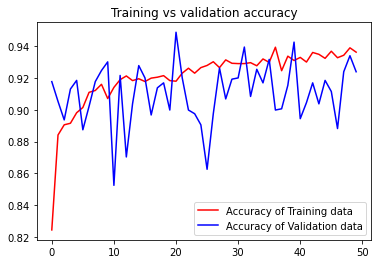

<Figure size 432x288 with 0 Axes>

In [12]:
get_acc = history1.history['accuracy']
value_acc = history1.history['val_accuracy']
get_loss = history1.history['loss']
validation_loss = history1.history['val_loss']

epochs = range(len(get_acc))
plt.plot(epochs, get_acc, 'r', label='Accuracy of Training data')
plt.plot(epochs, value_acc, 'b', label='Accuracy of Validation data')
plt.title('Training vs validation accuracy')
plt.legend(loc=0)
plt.figure()
plt.show()

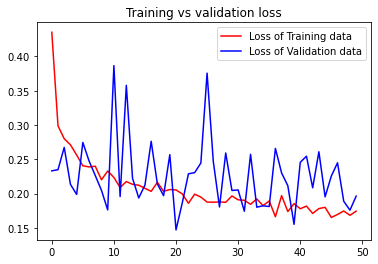

<Figure size 432x288 with 0 Axes>

In [13]:
epochs = range(len(get_loss))
plt.plot(epochs, get_loss, 'r', label='Loss of Training data')
plt.plot(epochs, validation_loss, 'b', label='Loss of Validation data')
plt.title('Training vs validation loss')
plt.legend(loc=0)
plt.figure()
plt.show()

In [14]:
model.save("covidModelMAIN1STVgg16SAIF.h5")

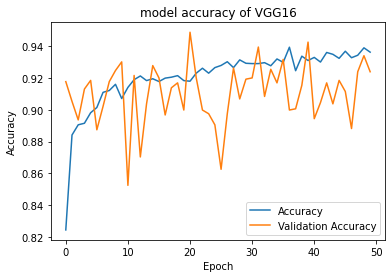

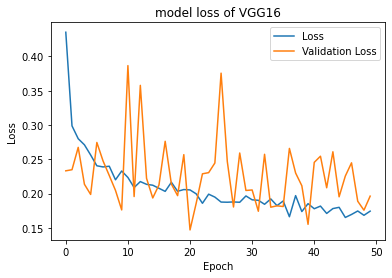

In [15]:
import matplotlib.pyplot as plt
plt.plot(history1.history['accuracy'])
plt.plot(history1.history['val_accuracy'])
plt.title("model accuracy of VGG16")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Accuracy","Validation Accuracy"])
plt.show()
plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])
plt.title("model loss of VGG16")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["Loss","Validation Loss"])
plt.show()

In [27]:
from random import shuffle
from tqdm import tqdm  
import scipy
import skimage
from skimage.transform import resize

In [48]:
from sklearn.metrics import precision_score, recall_score,\
                            confusion_matrix, classification_report, \
                            accuracy_score, f1_score

In [17]:
class_dict = {0:'COVID19',1:'NORMAL',2:'PNEUMONIA'}

In [20]:
pred=model.predict(test_gen)

In [21]:
print(len(pred))

1288


In [22]:
y_test=[]
for i in range(26):
    y_test.extend(test_gen.__getitem__(i)[1])

In [23]:
print(len(y_test))
y_test=np.array(y_test)

416


In [24]:
y_test=np.argmax(y_test,axis=1)
pred= np.argmax(pred,axis=1)

In [25]:
print("pred \n",len(pred))
print("y_test \n",len(y_test))

pred 
 1288
y_test 
 416


In [26]:
print("y_test \n",y_test)
print("pred \n",pred)

y_test 
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1]
pred 
 [0 0 0 ... 2 2 2]


In [51]:
print(classification_report(test_gen.classes,pred))

              precision    recall  f1-score   support

           0       1.00      0.97      0.98       116
           1       0.79      0.95      0.86       317
           2       0.98      0.91      0.94       855

    accuracy                           0.92      1288
   macro avg       0.92      0.94      0.93      1288
weighted avg       0.93      0.92      0.93      1288



In [52]:
print(confusion_matrix(test_gen.classes,pred))

[[112   2   2]
 [  0 301  16]
 [  0  78 777]]


<AxesSubplot:>

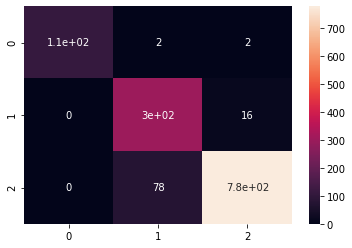

In [53]:
import seaborn as sns
sns.heatmap(confusion_matrix(test_gen.classes,pred), annot=True)

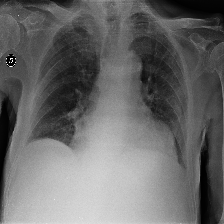

In [58]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
load_img("Data/test/COVID19/COVID19(461).jpg",target_size=(224,224))

In [61]:
image=load_img("Data/test/COVID19/COVID19(461).jpg",target_size=(224,224))

image=img_to_array(image) 
image=image/255.0
prediction_image=np.array(image)
prediction_image= np.expand_dims(image, axis=0)

In [62]:
reverse_mapping={0:'COVID19', 1:'NORMAL', 2:'PNEUMONIA'}

def mapper(value):
    return reverse_mapping[value]

prediction=model.predict(prediction_image)
value=np.argmax(prediction)
move_name=mapper(value)
print("Prediction is {}.".format(move_name))

Prediction is COVID19.


# actual

In [83]:
prediction4 = np.argmax(model.predict(test_gen), axis = -1)
prediction4

array([0, 0, 0, ..., 2, 2, 2], dtype=int64)

NameError: name 'getLabel' is not defined

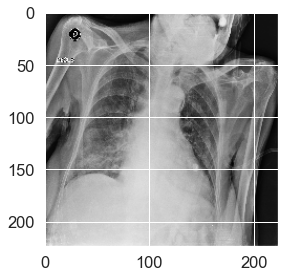

In [87]:
y_test4=[]
for i in range(41):
    y_test4.extend(test_gen.__getitem__(i)[1])
y_test4=np.array(y_test4)
plt.figure(figsize=(20,10))
fig = plt.gcf()
ncolumns,nrows=5,5
fig.set_size_inches(ncolumns*5, nrows*5)
for i in range(25):
    plt.subplot(nrows, ncolumns, i + 1)
    plt.imshow(test_gen.__getitem__(0)[0][i],cmap='gray')
    plt.title(f"REAL: {getLabel(y_test4[i])   } vs  PREDICT: {getLabel(prediction4[i])}")

In [89]:
from random import shuffle
from tqdm import tqdm  
import scipy
import skimage
from skimage.transform import resize

NameError: name 'getLabel' is not defined

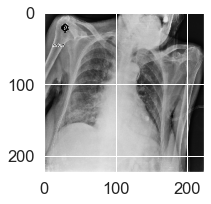

In [90]:
plt.figure(figsize=(20,10))
for i in range(0,9):
    
    plt.subplot(3, 3, i + 1)
    
    plt.imshow(test_gen.__getitem__(0)[0][i],cmap='gray')
    plt.title(f"   Real: {getLabel(y_test[i])   } Vs  Predict: {getLabel(pred[i])}")

In [94]:
import seaborn as sns
import sklearn.metrics as metrics
from sklearn.metrics import roc_curve, auc